In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.reshape(2735,18,1)
X_test.reshape(684,18,1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=96, max_value=256, step=16)
  model.add(SimpleRNN(hp_units, input_shape=(18, 1), return_sequences=True))
  model.add(Dropout(0.5))

  # Second SimpleRNN layer
  hp_units2 = hp.Int('units2', min_value=16, max_value=96, step=8)
  model.add(SimpleRNN(hp_units2, return_sequences=True))
  model.add(Dropout(0.5))

  # Third SimpleRNN layer
  model.add(SimpleRNN(hp_units2, return_sequences=False))  # This will output a single vector for the next layer
  model.add(Dropout(0.5))

  # Dense layer with more units
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense(1, activation = 'sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     directory='rnn_bayes_opt',
                     project_name='rnn_bayes_opt')


Reloading Tuner from rnn_bayes_opt\rnn_bayes_opt\tuner0.json


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 1e-06.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=1000, validation_split=0.2)


Epoch 1/1000


c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




69/69 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.5288

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 [==============================] - 15s 50ms/step - loss: 0.8118 - accuracy: 0.5288 - val_loss: 0.6712 - val_accuracy: 0.6271
Epoch 2/1000
69/69 [==============================] - 2s 24ms/step - loss: 0.8256 - accuracy: 0.5315 - val_loss: 0.6712 - val_accuracy: 0.6271
Epoch 3/1000
69/69 [==============================] - 2s 23ms/step - loss: 0.8107 - accuracy: 0.5324 - val_loss: 0.6714 - val_accuracy: 0.6271
Epoch 4/1000
69/69 [==============================] - 2s 24ms/step - loss: 0.7925 - accuracy: 0.5398 - val_loss: 0.6714 - val_accuracy: 0.6271
Epoch 5/1000
69/69 [==============================] - 2s 24ms/step - loss: 0.8175 - accuracy: 0.5370 - val_loss: 0.6715 - val_accuracy: 0.6271
Epoch 6/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.7911 - accuracy: 0.5553 - val_loss: 0.6715 - val_accuracy: 0.6271
Epoch 7/1000
69/69 [==============================] - 2s 23ms/step - loss: 0.8217 - accuracy: 0.5306 - val_loss: 0.6715 - val_accuracy: 0.6271
Epoch 8/100

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 750


In [12]:
history = model.fit(X_train, Y_train, epochs=1000, validation_split=0.2)

Epoch 1/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.6954 - accuracy: 0.5992 - val_loss: 0.6592 - val_accuracy: 0.6197
Epoch 2/1000
69/69 [==============================] - 1s 17ms/step - loss: 0.6970 - accuracy: 0.6015 - val_loss: 0.6592 - val_accuracy: 0.6197
Epoch 3/1000
69/69 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.5855 - val_loss: 0.6591 - val_accuracy: 0.6197
Epoch 4/1000
69/69 [==============================] - 1s 13ms/step - loss: 0.7050 - accuracy: 0.5800 - val_loss: 0.6592 - val_accuracy: 0.6197
Epoch 5/1000
69/69 [==============================] - 1s 16ms/step - loss: 0.7049 - accuracy: 0.5923 - val_loss: 0.6592 - val_accuracy: 0.6197
Epoch 6/1000
69/69 [==============================] - 1s 16ms/step - loss: 0.7013 - accuracy: 0.5864 - val_loss: 0.6592 - val_accuracy: 0.6197
Epoch 7/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.6969 - accuracy: 0.5873 - val_loss: 0.6592 - val_accuracy: 0.6197

In [13]:
model.save_weights('/Users/eddie/SSTP-Injury/Agriculture/Deep/RNN_Weights')
res = model.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0   0.488889  0.086275  0.146667       255
           1   0.635368  0.946387  0.760300       429

    accuracy                       0.625731       684
   macro avg   0.562128  0.516331  0.453483       684
weighted avg   0.580759  0.625731  0.531533       684



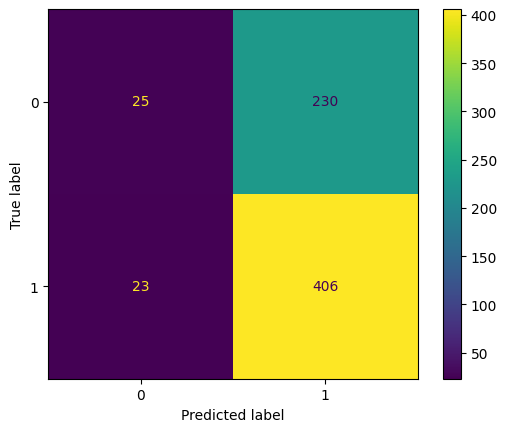

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 301it [08:01,  1.60s/it]                         


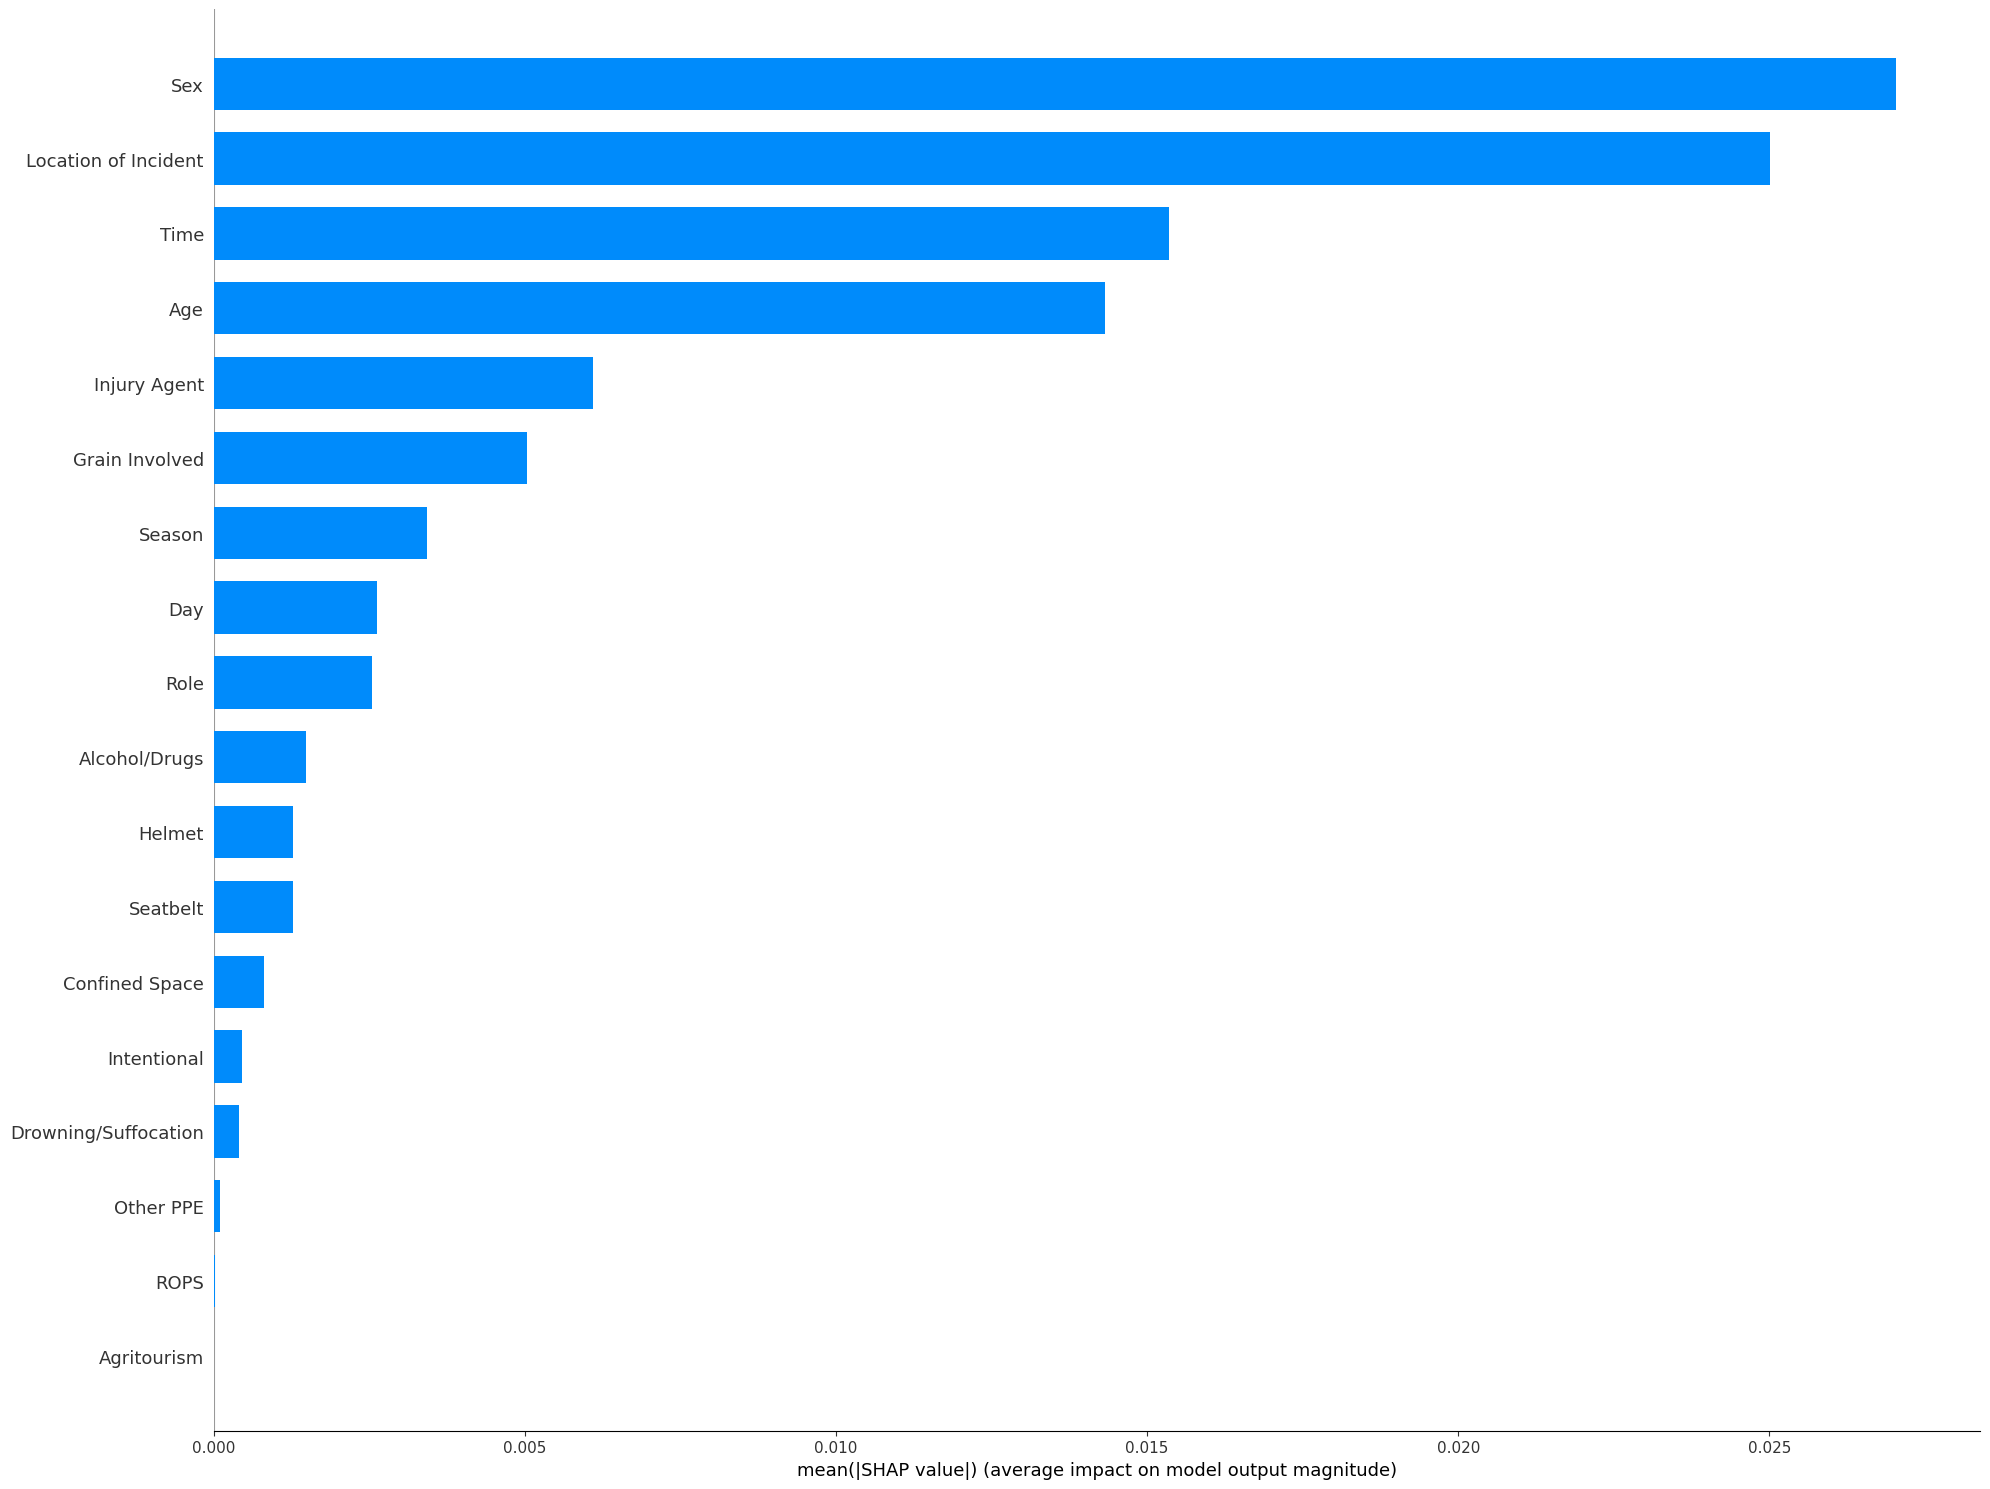

PermutationExplainer explainer: 301it [16:30,  3.32s/it]                         


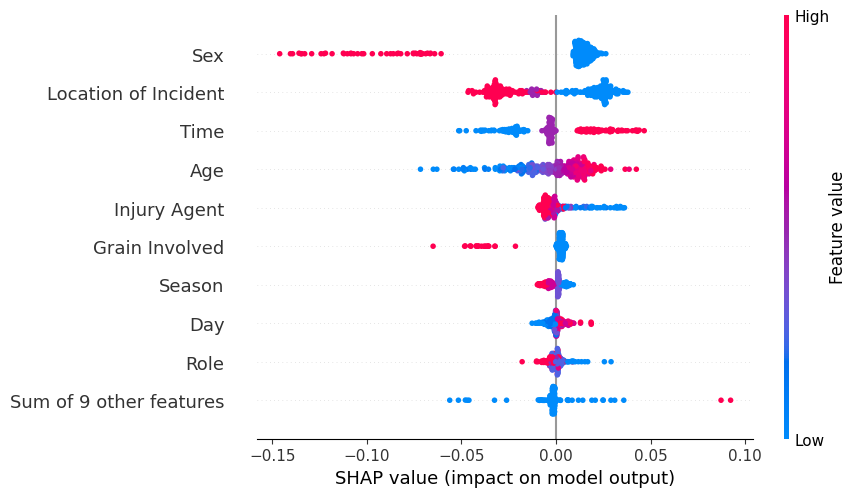

In [11]:
import shap
X_test_shap = shap.sample(X_train,nsamples = 300)
explainer = shap.Explainer(model, X_test_shap)
shap_values = explainer.shap_values(X_test_shap)
shap.summary_plot(shap_values, feature_names=features, plot_type="bar", plot_size=(20,15))
explanation = explainer(X_test_shap)
explanation = shap.Explanation(
    values=explanation, 
    feature_names=features
)
shap.plots.beeswarm(explanation)